## Database Connection

In [17]:
import numpy as np
import pandas as pd
import mysql.connector
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


#### Dumping data to MySQL

In [2]:
# # List of CSV files and their corresponding table names
# csv_files = [
#     ('customers.csv', 'customers'),
#     ('orders.csv', 'orders'),
#     ('sellers.csv', 'sellers'),
#     ('products.csv', 'products'),
#     ('geolocation.csv', 'geolocation'),
#     ('payments.csv', 'payments'),
#     ('order_items.csv', 'order_items')               # Added payments.csv for specific handling
# ]

# # Connect to the MySQL database
# conn = mysql.connector.connect(
#     host='localhost',
#     user='root',
#     password='12345',
#     database='ecommerce'
# )
# cursor = conn.cursor()

# # Folder containing the CSV files
# folder_path = 'E:\MYSQL\Project\Ecommerce_(Target)'

# def get_sql_type(dtype):
#     if pd.api.types.is_integer_dtype(dtype):
#         return 'INT'
#     elif pd.api.types.is_float_dtype(dtype):
#         return 'FLOAT'
#     elif pd.api.types.is_bool_dtype(dtype):
#         return 'BOOLEAN'
#     elif pd.api.types.is_datetime64_any_dtype(dtype):
#         return 'DATETIME'
#     else:
#         return 'TEXT'

# for csv_file, table_name in csv_files:
#     file_path = os.path.join(folder_path, csv_file)
    
#     # Read the CSV file into a pandas DataFrame
#     df = pd.read_csv(file_path)
    
#     # Replace NaN with None to handle SQL NULL
#     df = df.where(pd.notnull(df), None)
    
#     # Debugging: Check for NaN values
#     print(f"Processing {csv_file}")
#     print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

#     # Clean column names
#     df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

#     # Generate the CREATE TABLE statement with appropriate data types
#     columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
#     create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
#     cursor.execute(create_table_query)

#     # Insert DataFrame data into the MySQL table
#     for _, row in df.iterrows():
#         # Convert row to tuple and handle NaN/None explicitly
#         values = tuple(None if pd.isna(x) else x for x in row)
#         sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
#         cursor.execute(sql, values)

#     # Commit the transaction for the current CSV file
#     conn.commit()

# # Close the connection
# conn.close()

#### Establishing Connection 

In [3]:
db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Nblhn321@",
                            database = "ecommerce")

# activate the cursor
cur = db.cursor()

## Queries

### 1. List all unique cities where customers are located.

In [4]:
query = """ SELECT DISTINCT(customer_city) FROM customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['distinct_city'])
df

,distinct_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


### 2. Count the number of orders placed in 2017.

In [5]:
query = """ SELECT COUNT(order_id) 
            FROM orders 
            WHERE YEAR(order_purchase_timestamp) = 2017 
        """

cur.execute(query)

data = cur.fetchall()
data[0][0]

45101

### 3. Find the total sales per category.

In [6]:
query = """ SELECT UPPER(pd.product_category), ROUND(SUM(py.payment_value), 2)
            FROM products AS pd
            INNER JOIN order_items AS oi   ON oi.product_id = pd.product_id
            INNER JOIN payments AS py      ON py.order_id = oi.order_id
            GROUP BY pd.product_category
        """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['category', 'sales'])
df

,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


### 4. Calculate the percentage of orders that were paid in installments.

In [7]:
query = """ SELECT (SELECT COUNT(payment_installments)  FROM payments  WHERE payment_installments >= 1) / 
            COUNT(*) * 100
            FROM payments 
        """

# query = """ select ((sum(case when payment_installments >= 1 then 1
#             else 0 end))/count(*))*100 from payments
#         """

cur.execute(query)

data = cur.fetchall()
data[0][0]

Decimal('99.9981')

### 5. Count the number of customers from each state.

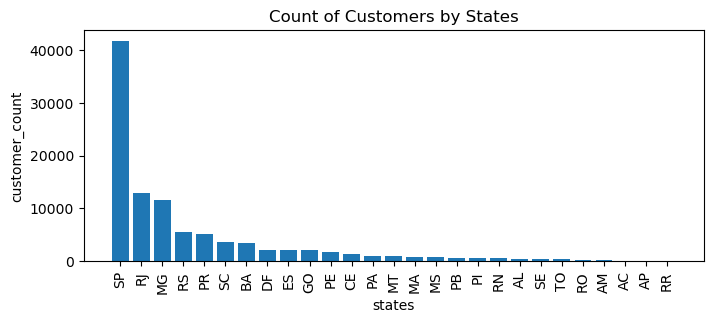

In [8]:
query = """ SELECT customer_state, COUNT(customer_id) 
            FROM customers 
            GROUP BY customer_state
        """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['state', 'customer_count'])
df = df.sort_values('customer_count', ascending=False)

plt.figure(figsize= (8,3))
plt.bar(df['state'], df['customer_count'])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

### 6. Calculate the number of orders per month in 2018.`

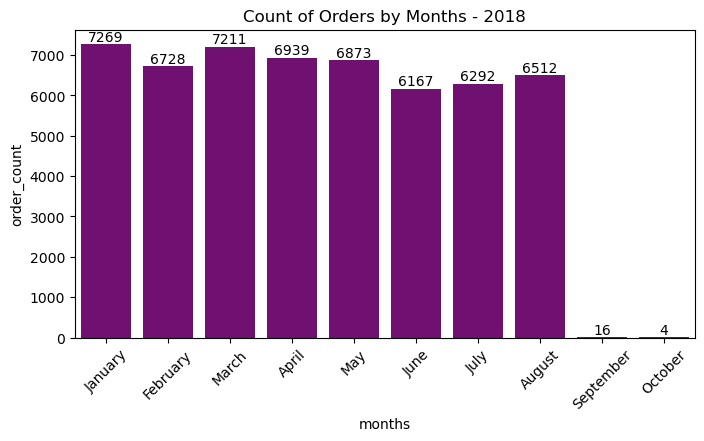

In [9]:
query = """ SELECT MONTHNAME(order_purchase_timestamp) AS month, COUNT(order_id) 
            FROM orders 
            WHERE YEAR(order_purchase_timestamp) = 2018 
            GROUP BY month
        """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['months', 'order_count'])
df = df.sort_values('order_count', ascending=False)

plt.figure(figsize= (8,4))
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "purple")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months - 2018")
plt.show()

### 7. Find the average number of products per order, grouped by customer city.

In [10]:
query = """ WITH cte AS (
                        SELECT o.order_id, o.customer_id, COUNT(o.order_id) AS order_count
                        FROM orders AS o   
                        INNER JOIN order_items AS oi ON oi.order_id = o.order_id
                        GROUP BY o.order_id, o.customer_id
                        )
                        
            SELECT c.customer_city, ROUND(AVG(order_count), 2) AS avg_order
            FROM cte 
            INNER JOIN customers AS c ON c.customer_id = cte.customer_id
            GROUP BY c.customer_city
            ORDER BY avg_order DESC
        """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['customer_city', 'avg_products_per_orders'])
df

,customer_city,avg_products_per_orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
...,...,...
4105,lagoa da canoa,1.00
4106,japaratuba,1.00
4107,sebastiao leal,1.00
4108,morro agudo de goias,1.00


### 8. Calculate the percentage of total revenue contributed by each product category.

In [11]:
query = """ SELECT UPPER(pd.product_category) AS category, 
            ROUND((SUM(py.payment_value) / (SELECT SUM(payment_value) FROM payments))*100, 2) AS percentage_of_total_revenue
            FROM products AS pd
            INNER JOIN order_items AS oi   ON oi.product_id = pd.product_id
            INNER JOIN payments AS py      ON py.order_id = oi.order_id
            GROUP BY pd.product_category
            ORDER BY percentage_of_total_revenue DESC
        """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['category', 'percentage_distribution'])
df


,category,percentage_distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


### 9. Identify the correlation between product price and the number of times a product has been purchased.

In [37]:
query = """ SELECT UPPER(p.product_category), COUNT(oi.order_id), ROUND(AVG(oi.price), 2)
            FROM products AS p 
            INNER JOIN order_items AS oi  ON p.product_id = oi.product_id 
            GROUP BY p.product_category
        """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['category', 'order_count', 'avg_price'])

arr1 = np.array(df['order_count'])
arr2 = np.array(df['avg_price'])
a = np.corrcoef(arr1, arr2)
a

# corr_df = pd.DataFrame(a, index=['Order Count', 'Avg Price'], columns=['Order Count', 'Avg Price'])
# plt.figure(figsize=(5, 3))
# sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
# plt.title("Correlation Heatmap between Order Count and Avg Price")
# plt.show()

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

### 10. Calculate the total revenue generated by each seller, and rank them by revenue.

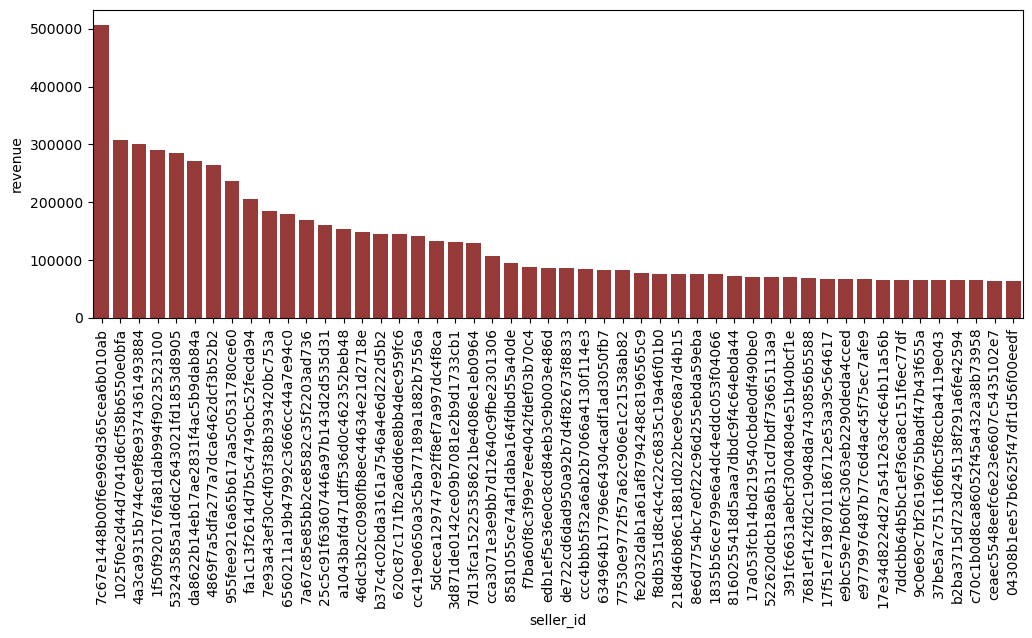

In [52]:
query = """ SELECT *,
            DENSE_RANK() OVER( ORDER BY revenue DESC) AS rnk
            FROM (  SELECT oi.seller_id, ROUND(SUM(p.payment_value), 2) AS revenue
                    FROM payments AS p 
                    INNER JOIN order_items AS oi  ON p.order_id = oi.order_id 
                    GROUP BY oi.seller_id
                 ) AS sub_query
        """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['seller_id', 'revenue', 'rank'])
df = df.head(50)

plt.figure(figsize= (12,4))
sns.barplot(x = "seller_id", y = "revenue", data = df, color = 'brown')
plt.xticks(rotation = 90)
plt.show()

### 11. Calculate the moving average of order values for each customer over their order history.

In [59]:
# query = """ SELECT customer_id, order_purchase_timestamp, payment, 
#             AVG(payment) OVER(PARTITION BY customer_id ORDER BY order_purchase_timestamp ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) as mov_avg
#             FROM (
#                     SELECT o.customer_id, o.order_purchase_timestamp, p.payment_value AS payment
#                     FROM payments AS p
#                     INNER JOIN orders AS o ON o.order_id = p.order_id 
#                  ) AS sub_query
#         """

query = """ WITH cte AS (
                            SELECT o.customer_id, o.order_purchase_timestamp, p.payment_value AS payment
                            FROM payments AS p
                            INNER JOIN orders AS o ON o.order_id = p.order_id 
                        )

            SELECT customer_id, order_purchase_timestamp, payment, 
            AVG(payment) OVER (PARTITION BY customer_id ORDER BY order_purchase_timestamp ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS mov_avg
            FROM cte;
        """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['customer_id', 'order_purchase_timestamp', 'payment', 'mov_avg_payment'])
df.head(50)

,customer_id,order_purchase_timestamp,payment,mov_avg_payment
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.709961


### 12. Calculate the cumulative sales per month for each year.

In [73]:
query = """ SELECT years, months, payment, 
            SUM(payment) OVER (ORDER BY years, months) AS cummaltive_Sales
            FROM (
                    SELECT YEAR(o.order_purchase_timestamp) AS years, MONTH(o.order_purchase_timestamp) AS months, 
                    ROUND(SUM(p.payment_value), 2) AS payment
                    FROM payments AS p
                    INNER JOIN orders AS o ON o.order_id = p.order_id 
                    GROUP BY years, months
                    ORDER BY years, months
                 ) AS sub_query
        """

# query = """ WITH cte AS (
#                             SELECT YEAR(o.order_purchase_timestamp) AS years, MONTHNAME(o.order_purchase_timestamp) AS months, 
#                             ROUND(SUM(p.payment_value), 2) AS payment
#                             FROM payments AS p
#                             INNER JOIN orders AS o ON o.order_id = p.order_id 
#                             GROUP BY years, months
#                             ORDER BY years, months 
#                         )

#             SELECT years, months, payment, 
#             SUM(payment) OVER (ORDER BY years, months DESC) AS cummaltive_Sales
#             FROM cte 
#         """


cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['years', 'months', 'payment', 'cummulative_sales'])
df

,years,months,payment,cummulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


### 13. Calculate the year-over-year growth rate of total sales.

In [83]:
# query = """ SELECT years, ((payment - LAG(payment, 1) OVER (ORDER BY years) ) / LAG(payment, 1) OVER (ORDER BY years)) * 100
#             FROM (
#                     SELECT YEAR(o.order_purchase_timestamp) AS years, ROUND(SUM(p.payment_value), 2) AS payment
#                     FROM payments AS p
#                     INNER JOIN orders AS o ON o.order_id = p.order_id 
#                     GROUP BY years
#                     ORDER BY years
#                  ) AS sub_query
#          """


query = """  WITH cte AS (
                        SELECT YEAR(o.order_purchase_timestamp) AS years, ROUND(SUM(p.payment_value), 2) AS payment
                        FROM payments AS p
                        INNER JOIN orders AS o ON o.order_id = p.order_id 
                        GROUP BY years
                        ORDER BY years
                         )
                         
            SELECT years, ((payment - LAG(payment, 1) OVER (ORDER BY years) ) / LAG(payment, 1) OVER (ORDER BY years)) * 100
            FROM cte
            
        """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['years', 'YOY_growth%'])
df

,years,YOY_growth%
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


### 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [84]:
query = """  WITH cte1 AS (
                        SELECT c.customer_id, MIN(o.order_purchase_timestamp) AS first_order
                        FROM customers AS c
                        INNER JOIN orders AS o ON o.customer_id = c.customer_id 
                        GROUP BY c.customer_id
                         ), 
                         
                  cte2 AS (
                        SELECT cte1.customer_id, COUNT(DISTINCT o.order_purchase_timestamp) AS next_order
                        FROM cte1
                        INNER JOIN orders AS o ON o.customer_id = cte1.customer_id 
                        AND o.order_purchase_timestamp > cte1.first_order 
                        AND o.order_purchase_timestamp < DATE_ADD(cte1.first_order, INTERVAL 6 MONTH)
                        GROUP BY cte1.customer_id
                        )
                
            SELECT 100 * (COUNT( DISTINCT cte1.customer_id)/ COUNT(DISTINCT cte2.customer_id)) 
            FROM cte1 LEFT JOIN cte2 
            ON cte1.customer_id = cte2.customer_id    
            
        """

cur.execute(query)

data = cur.fetchall()
data

# df = pd.DataFrame(data, columns = ['years', 'YOY_growth%'])
# df

[(None,)]

### 15. Identify the top 3 customers who spent the most money in each year.

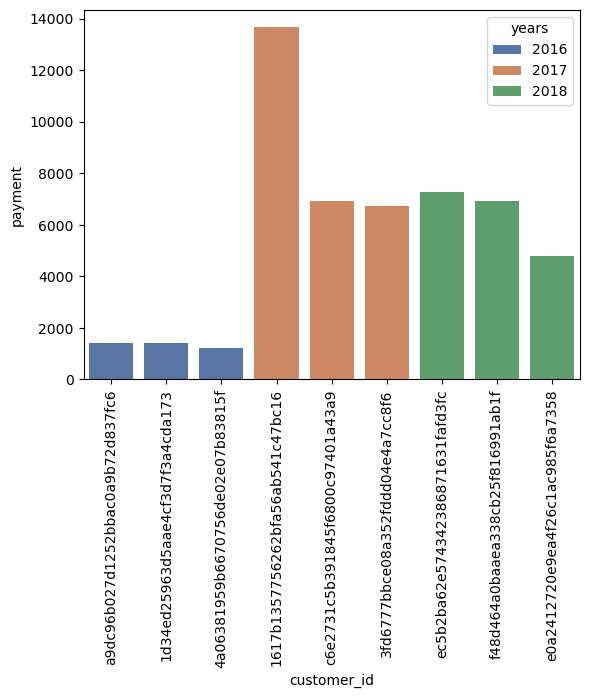

In [98]:
query = """ WITH cte AS (
                        SELECT YEAR(o.order_purchase_timestamp) AS years, o.customer_id, ROUND(SUM(p.payment_value), 2) AS payment,
                        DENSE_RANK() OVER (PARTITION BY YEAR(o.order_purchase_timestamp) ORDER BY ROUND(SUM(p.payment_value), 2) DESC) AS dense_rnk
                        FROM payments AS p
                        INNER JOIN orders AS o ON o.order_id = p.order_id 
                        GROUP BY YEAR(o.order_purchase_timestamp), o.customer_id
                        )  
           SELECT  years, customer_id, payment, dense_rnk
           FROM cte
           WHERE dense_rnk <= 3
            
        """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['years', 'customer_id', 'payment', 'desne_rnk'])

sns.barplot(x = "customer_id", y = "payment", data = df, palette= "deep", hue = "years")
plt.xticks(rotation = 90)
plt.show()